# 数据集目录结构
```
FashionAI-Attributes
├── models/
├── data/
│   ├── base/
│   └── rank/
└── solution.ipynb
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 设置训练任务
本次比赛训练八个不同任务图片分类器，要想处理其他类型的服饰，只需要将task变量指定为对应的服饰类型名称就行了。

In [7]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels', 
           'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels', 
           'pant_length_labels']
task = classes[0]

# 查看图片数据示例

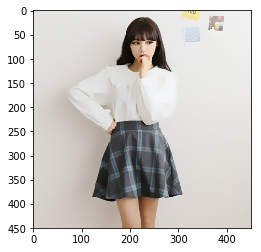

In [8]:
data_path = os.path.join("data/base/Images/", task)

first_image_path = os.path.join(data_path, os.listdir(data_path)[0])
img = plt.imread(first_image_path)
plt.imshow(img);

# 数据整理
Keras提供了一个读取图像分类任务数据的接口keras.preprocessing.image.ImageDataGenerator，它期望数据是类似ImageNet的格式组织的，即每一类图片都统一放在一个目录下。因此我们需要将数据进行整理，并且取10%的数据作为验证集。

In [6]:
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
mkdir_if_not_exist(['data/base/train_valid'])

In [79]:
label_path = 'data/base/Annotations/label.csv'

image_path = []

with open(label_path, 'r') as f:
    lines = f.readlines()
    tokens = [l.rstrip().split(',') for l in lines]
    for path, tk, label in tokens:
        if tk == task:
            image_path.append(('data/base/' + path, label))

In [81]:
print(image_path[0])
print(len(image_path))

('data/base/Images/collar_design_labels/4d8a38b29930a403e5e2167c6e2327b5.jpg', 'nnynn')
8393


### 构建训练集和测试集数据目录，以及类别的子目录
假设当前分类任务为collar_design_labels，则运行后的目录结构如下:
```
train_valid
└── collar_design_labels
    ├── train
    │   ├── 0
    │   ├── 1
    │   ├── 2
    │   ├── 3
    │   └── 4
    └── val
        ├── 0
        ├── 1
        ├── 2
        ├── 3
        └── 4
```

In [89]:
mkdir_if_not_exist(['data/train_valid', task])
mkdir_if_not_exist(['data/train_valid', task, 'train'])
mkdir_if_not_exist(['data/train_valid', task, 'valid'])
for n in range(task_class):
    mkdir_if_not_exist(['data/train_valid', task, 'train', str(n)])
    mkdir_if_not_exist(['data/train_valid', task, 'valid', str(n)])

### 数据复制
将图片数据复制到各自对应的目录，需要注意的是，这里我们刻意随机打乱了图片的顺序，从而防止训练集与测试集切分不均匀的情况出现。

In [90]:
import random, shutil

n = len(image_path)
random.seed(1024)
random.shuffle(image_path)

In [91]:
train_count = 0
for path, label in image_path:
    label_index = list(label).index('y')
    if train_count < n * 0.9:
        shutil.copy(path,
                    os.path.join('data/train_valid', task, 'train', str(label_index)))
    else:
        shutil.copy(path,
                    os.path.join('data/train_valid', task, 'valid', str(label_index)))
    train_count += 1

# 算法设计——微调版迁移学习

In [92]:
image_size = 256
batch_size = 32
epochs = 100
train_data_path = os.path.join('data/train_valid', task, 'train')
valid_data_path = os.path.join('data/train_valid', task, 'valid')

In [93]:
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input

ImportError: No module named 'keras'

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=20, shear_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='categorical')

In [ ]:
base_model = ResNet50(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    if re.search(r'^res5', layer.name) is not None:
        layer.trainable = True
    else:
         layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)
predictions = Dense(task_class, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers: 
    layer.trainable = False  
    
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

histroy = model.fit_generator(train_generator,
                            train_generator.n // batch_size, 
                            epochs=epochs, 
                            workers=4,
                            validation_data=validation_generator,
                            validation_steps=validation_generator.n // batch_size)
model.save('models/clasif_model3.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()